<a href="https://colab.research.google.com/github/Takfes/notes-reinforcement-learning/blob/main/notebooks/003_gym_taxi_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
sudo apt-get update
apt install swig cmake
pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit1/requirements-unit1.txt

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,978 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,116 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [17]:
%%bash
apt install python3-opengl
apt install ffmpeg
apt install xvfb
pip3 install pyvirtualdisplay pygame tqdm

Reading package lists...
Building dependency tree...
Reading state information...
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.


In [ ]:
# import os
# os.kill(os.getpid(), 9)

In [3]:
# Virtual display
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Q Learning
* Update Rule : $Q(s,a) ← Q(s,a) + α (r + γ * max_{a′}Q(s′,a′)−Q(s,a))$
* Update Rule : $NewEstimate ← OldEstimate + StepSize * [Target - OldEstimate]$
* [Hugging Face Taxi Hands On Tutorial](https://huggingface.co/learn/deep-rl-course/unit2/hands-on)
* [OpenAI Gymnasium Taxi Documentation](https://gymnasium.farama.org/environments/toy_text/taxi/#taxi)

In [41]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [47]:
def initialize_q_table(env):
    Qtable = np.zeros([env.observation_space.n, env.action_space.n])
    return Qtable

def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state][:])
  return action

def epsilon_greedy_policy(Qtable,state,epsilon,env):
    if np.random.random() > epsilon:
        action = greedy_policy(Qtable,state)
    else:
        action = env.action_space.sample()
    return action

def Qtable_update(Qtable,state,action,reward,new_state,learning_rate_a=0.9,discount_rate_g=0.9):
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    Qtable[state, action] = Qtable[state, action] + learning_rate_a * (
                    reward + discount_rate_g * np.max(Qtable[new_state,:]) - Qtable[state, action])
    return Qtable

def epsilon_update(epsilon, epsilon_decay, epsilon_min):
    epsilon = max(epsilon - epsilon_decay, epsilon_min)
    return epsilon

def learning_rate_update(learning_rate,epsilon,epsilon_min):
    # decrease learning rate once epsilon has fully decayed
    return 0.001 if epsilon<=epsilon_min else learning_rate

def train(
        env,
        episodes,
        epsilon = 1,
        epsilon_min = 0,
        epsilon_decay = 0.0001,
        learning_rate_a = 0.9,
        discount_rate_g = 0.9
        ):
    Qtable = initialize_q_table(env)
    all_episode_rewards = np.zeros(episodes)
    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        terminated, truncated = False, False
        this_episode_rewards = 0
        while not(terminated or truncated):
            action = epsilon_greedy_policy(Qtable,state,epsilon,env)
            new_state, reward, terminated, truncated, info = env.step(action)
            Qtable = Qtable_update(Qtable,state,action,reward,new_state,learning_rate_a,discount_rate_g)
            state = new_state
            this_episode_rewards += reward
        all_episode_rewards[episode] = this_episode_rewards
        epsilon = epsilon_update(epsilon, epsilon_decay, epsilon_min)
        learning_rate_a = learning_rate_update(learning_rate_a,epsilon,epsilon_min)
    return Qtable, all_episode_rewards

def evaluate_agent(env, n_eval_episodes, Qtable, render = False):
    all_episode_rewards = np.zeros(n_eval_episodes)
    for episode in tqdm(range(n_eval_episodes)):
        state, _ = env.reset()
        terminated, truncated = False, False
        this_episode_rewards = 0
        while not(terminated or truncated):
            action = greedy_policy(Qtable,state)
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            this_episode_rewards += reward
            # visualize environment
            if render:
                screen = env.render()
                plt.imshow(screen)
                ipythondisplay.clear_output(wait=True)
                plt.pause(0.5)
            if terminated or truncated:
                break
        all_episode_rewards[episode] = this_episode_rewards
    mean_reward = np.mean(all_episode_rewards)
    std_reward = np.std(all_episode_rewards)
    print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")
    return mean_reward,std_reward

### Training

In [51]:
env_id = 'Taxi-v3'
render_mode = 'rgb_array'
episodes = 15_000
discount_rate_g = 0.9
learning_rate_a = 0.9
epsilon = 1
epsilon_decay = 0.0001
epsilon_min = 0
print(f"Episodes till epsilon decays : {epsilon/epsilon_decay:,.0f}")

Episodes till epsilon decays : 10,000


In [52]:
env = gym.make(env_id, render_mode=render_mode)
print(f'Enviornment {env_id}, action space : {env.action_space.n}, observation space : {env.observation_space.n}')

Enviornment Taxi-v3, action space : 6, observation space : 500


In [44]:
Qtable, rewards = train(env, episodes, epsilon, epsilon_min, epsilon_decay, learning_rate_a, discount_rate_g)

100%|██████████| 15000/15000 [00:31<00:00, 469.60it/s] 


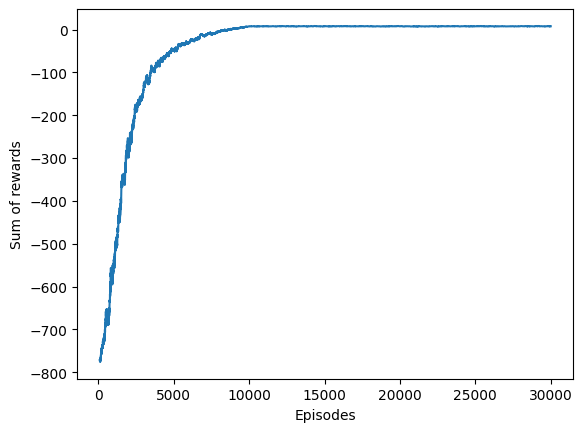

In [42]:
# plot training progress
rewards_smoothed = pd.Series(rewards).rolling(100).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards")
plt.show()

### Evaluation

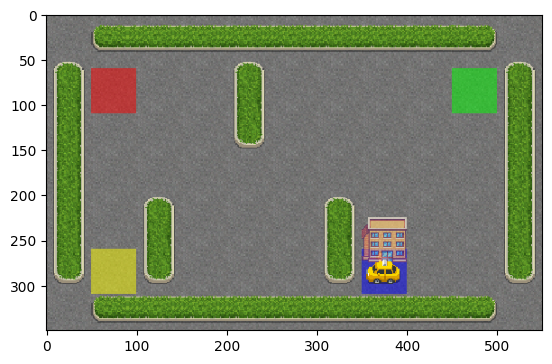

100%|██████████| 1/1 [00:12<00:00, 12.69s/it]

Mean reward: 7.00 +/- 0.00


(7.0, 0.0)

In [50]:
evaluate_agent(env,1,Qtable,render=True)